In [9]:
STARTEGIES = [
    # "CPU_1CORE_LINEAR",
    # "CPU_NCORE_LINEAR",
    "CPU_1CORE_BINARY",
    "CPU_NCORE_BINARY",
    "CPU_1CORE_BINARY_ONEWAY",
    "CPU_NCORE_BINARY_ONEWAY",
    # "GPU_LINEAR",
    "GPU_BINARY",
    "GPU_BINARY_ONEWAY",
]

In [10]:
import random
import subprocess


INDEX_CACHE = {}
def index_file(filename: str) -> list[int]:
    if filename in INDEX_CACHE:
        return INDEX_CACHE[filename]
    result = []
    with open(filename, 'r') as f:
        file_end = f.seek(0, 2)
        f.seek(0)
        while f.tell() < file_end:
            result.append(f.tell())
            f.readline()
    INDEX_CACHE[filename] = result
    return result

def generate_random_query(size: int, base_database: str, output_file: str):
    database_index = index_file(base_database)
    database_size = len(database_index)

    with open(output_file, 'w') as f:
        database_f = open(base_database, 'r')
        for idx in range(size):
            query_pos = random.randint(2, database_size - 1)
            query = database_index[query_pos]
            database_f.seek(query)
            query = database_f.readline().strip()
            chrom, pos, ref, alt = query.split('\t')[:4]
            id = f"random_{idx}"
            query = f"{chrom}\t{pos}\t{id}\t{ref}\t{alt}"
            # print(idx, query)
            f.write(query + '\n')
        database_f.close()

In [11]:
# generate_random_query(10, "../data/dbNSFP4.5a_variant_100c_sorted.chr22", "query.txt")

In [12]:
import time
import re
import os
import pandas as pd

MODE = "debug"
EXEC = f"/home/tudny/Documents/UW/MIMUW/HPC/HPC-Cuda-PZ/cmake-build-{MODE}/gpugenv"
QUERY = "../data/h" + "omo_sapiens_GRCh38.vcf"
DATABASE = "../data/dbNSFP4.5a_variant_100c_sorted.chr22"
TIME_RE = re.compile("resolve_query - \[TIMEIT\] ([0-9A-Z_]+) - Time taken: (\d+)ms")
SIZES = [100, 1000, 10000]

!mkdir -p workdir
!rm -rf workdir/*.txt
!rm -rf workdir/*.out
!rm -rf workdir/*.vcf

# BIG_QUERY = "workdir/big_query.vcf"
# if not os.path.exists(BIG_QUERY):
#     with open(BIG_QUERY, "w") as f:
#         contents = open(QUERY).read()
#         for _ in range(100000):
#             f.write(contents)

# query = BIG_QUERY
HOW_MANY_TRIES = 1

!rm -rf workdir/index
if not os.path.exists("workdir/index"):
    !{EXEC} -i {DATABASE} workdir/index

times = {}
q_times = {}

%env OMP_THREAD_LIMIT=12

result_time_df = pd.DataFrame(columns=["strategy", "total_time", "query_time", "query_size"])

for query_size in SIZES:
    query = f"workdir/random_query_{query_size}.vcf"
    generate_random_query(query_size, DATABASE, query)
    for strategy in STARTEGIES:
        for _ in range(HOW_MANY_TRIES):
            print(f"Running {strategy}")
            begin_time = time.time()
            !{EXEC} {query} workdir/index workdir/output-{strategy}-{query_size}.txt {strategy} 2> workdir/stdout-{strategy}-{query_size}.out
            end_time = time.time()
            # print(f"Finished {strategy} in {end_time - begin_time} seconds")
            total_time = (end_time - begin_time)
            with open(f"workdir/stdout-{strategy}-{query_size}.out") as f:
                q_time = int(TIME_RE.findall(f.read())[0][1])
                query_time = q_time
            new_entry = {
                "strategy": strategy,
                "total_time": total_time,
                "query_time": query_time,
                "query_size": query_size
            }
            result_time_df = pd.concat([result_time_df, pd.DataFrame([new_entry])])
        print(f"Strategy {strategy} finished")



Mon May  6 18:46:17 2024 [DEBUG] /home/tudny/Documents/UW/MIMUW/HPC/HPC-Cuda-PZ/src/main.cc:9 - main - Running the main function
Mon May  6 18:46:17 2024 [DEBUG] /home/tudny/Documents/UW/MIMUW/HPC/HPC-Cuda-PZ/src/params.cc:13 - parse_args - Parsing the input arguments
Mon May  6 18:46:17 2024 [DEBUG] /home/tudny/Documents/UW/MIMUW/HPC/HPC-Cuda-PZ/src/params.cc:19 - parse_args - Parsing the input arguments as IndexingParams
Mon May  6 18:46:17 2024 [DEBUG] /home/tudny/Documents/UW/MIMUW/HPC/HPC-Cuda-PZ/src/indexer/indexer.cc:136 - index - Indexing the database: Database: ../data/dbNSFP4.5a_variant_100c_sorted.chr22 Index: workdir/index
Mon May  6 18:46:17 2024 [DEBUG] /home/tudny/Documents/UW/MIMUW/HPC/HPC-Cuda-PZ/src/common.cc:17 - validate_file_exists - Validating file exists: File: ../data/dbNSFP4.5a_variant_100c_sorted.chr22
Mon May  6 18:46:17 2024 [DEBUG] /home/tudny/Documents/UW/MIMUW/HPC/HPC-Cuda-PZ/src/common.cc:23 - validate_file_exists - File exists: ../data/dbNSFP4.5a_varian

/tmp/ipykernel_96845/1310171491.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_time_df = pd.concat([result_time_df, pd.DataFrame([new_entry])])


Strategy CPU_1CORE_BINARY_ONEWAY finished
Running CPU_NCORE_BINARY_ONEWAY
Strategy CPU_NCORE_BINARY_ONEWAY finished
Running GPU_BINARY
Strategy GPU_BINARY finished
Running GPU_BINARY_ONEWAY
Strategy GPU_BINARY_ONEWAY finished
Running CPU_1CORE_BINARY
Strategy CPU_1CORE_BINARY finished
Running CPU_NCORE_BINARY
Strategy CPU_NCORE_BINARY finished
Running CPU_1CORE_BINARY_ONEWAY
Strategy CPU_1CORE_BINARY_ONEWAY finished
Running CPU_NCORE_BINARY_ONEWAY
Strategy CPU_NCORE_BINARY_ONEWAY finished
Running GPU_BINARY
Strategy GPU_BINARY finished
Running GPU_BINARY_ONEWAY
Strategy GPU_BINARY_ONEWAY finished
Running CPU_1CORE_BINARY
Strategy CPU_1CORE_BINARY finished
Running CPU_NCORE_BINARY
Strategy CPU_NCORE_BINARY finished
Running CPU_1CORE_BINARY_ONEWAY
Strategy CPU_1CORE_BINARY_ONEWAY finished
Running CPU_NCORE_BINARY_ONEWAY
Strategy CPU_NCORE_BINARY_ONEWAY finished
Running GPU_BINARY
Strategy GPU_BINARY finished
Running GPU_BINARY_ONEWAY
Strategy GPU_BINARY_ONEWAY finished


In [13]:
result_time_df

,strategy,total_time,query_time,query_size
0,CPU_1CORE_BINARY,0.124768,0,100
0,CPU_NCORE_BINARY,0.167389,19,100
0,CPU_1CORE_BINARY_ONEWAY,0.130552,0,100
0,CPU_NCORE_BINARY_ONEWAY,0.150514,7,100
0,GPU_BINARY,0.226724,78,100
0,GPU_BINARY_ONEWAY,0.201074,54,100
0,CPU_1CORE_BINARY,0.129605,0,1000
0,CPU_NCORE_BINARY,0.152620,0,1000
0,CPU_1CORE_BINARY_ONEWAY,0.128458,0,1000
0,CPU_NCORE_BINARY_ONEWAY,0.147297,0,1000


In [28]:
for query_size in SIZES:
    last_result = None
    last_strategy = None
    for strategy in STARTEGIES:
        with open(f"workdir/output-{strategy}-{query_size}.txt") as f:
            result = set(map(lambda x: tuple(x.split('\t')[:4]), f.readlines()))
        if last_result:
            assert result == last_result, f"Results for {strategy} and {last_strategy} are different for {query_size}"
        last_result = result
        last_strategy = strategy


In [ ]:
import matplotlib.pyplot as plt

def boxplot_time(time_param: str, unit: str, io_str: str = ""):
    for query_size in SIZES:
        plt.figure()
        df = result_time_df[result_time_df["query_size"] == query_size]
        plt.boxplot([df[df["strategy"] == strategy][time_param] for strategy in STARTEGIES], labels=STARTEGIES)
        plt.title(f"Time taken to resolve query (with{io_str} IO) N={query_size}")
        plt.xticks(rotation=60, ha="right")
        plt.xlabel("Strategy")
        plt.ylabel(f"Time taken [{unit}]")
        plt.show()

def mean_bar_time(time_param: str, unit: str, io_str: str = ""):
    for query_size in SIZES:
        plt.figure()
        df = result_time_df[result_time_df["query_size"] == query_size]
        for strategy in STARTEGIES:
            strategy_mean_time = df[df["strategy"] == strategy][time_param].mean()
            plt.text(strategy, strategy_mean_time, f"{strategy_mean_time:.2f}", ha="center", va="bottom")
        data = df.groupby("strategy")[time_param].mean()
        plt.bar(data.index, data)
        plt.title(f"Time taken to resolve query (with{io_str} IO) N={query_size}")
        plt.xticks(rotation=60, ha="right")
        plt.xlabel("Strategy")
        plt.ylabel(f"Time taken [{unit}]")
        plt.show()

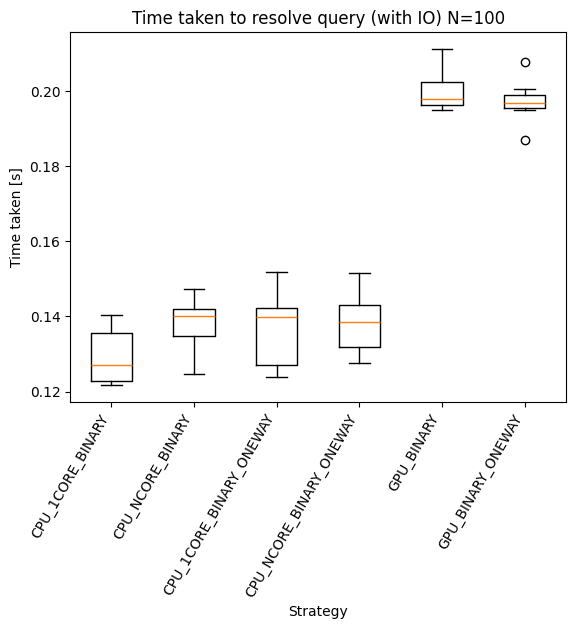

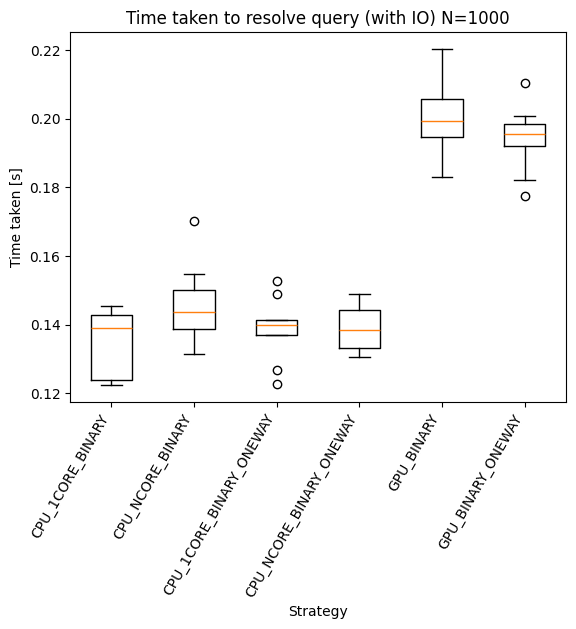

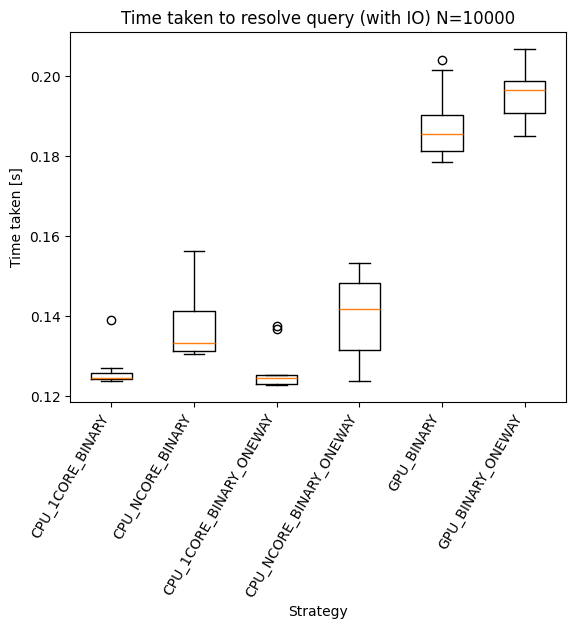

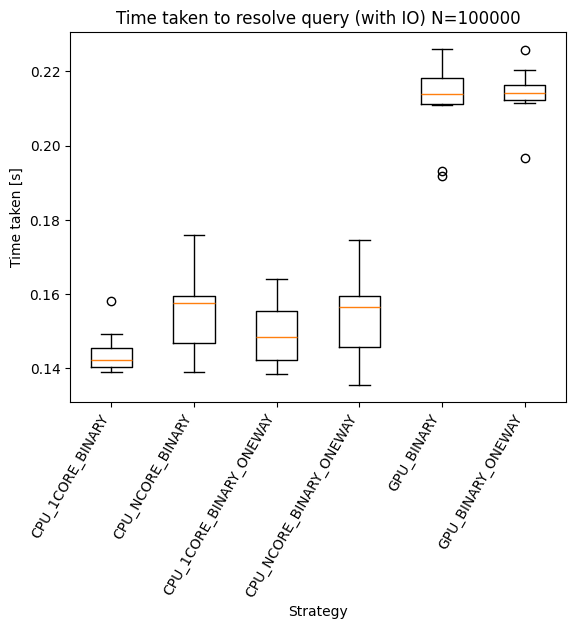

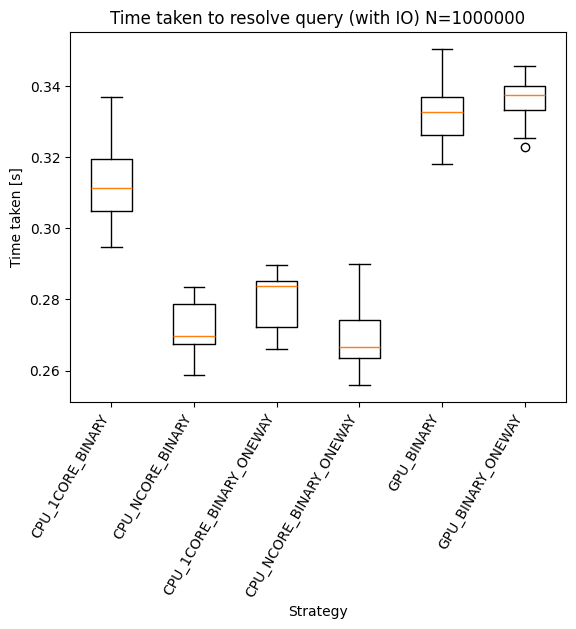

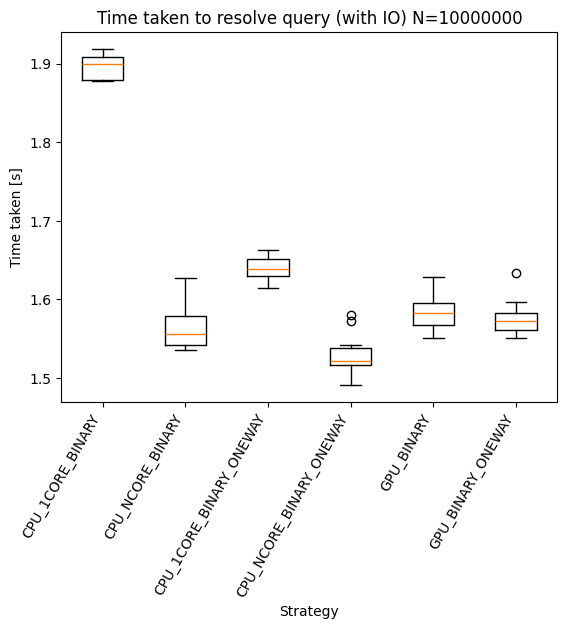

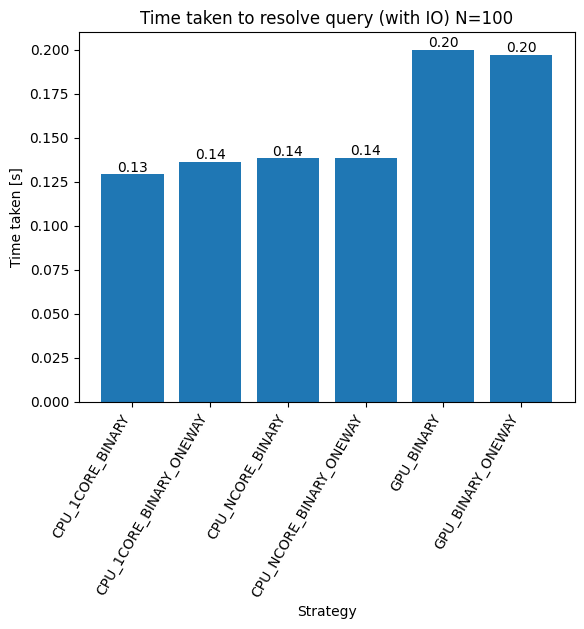

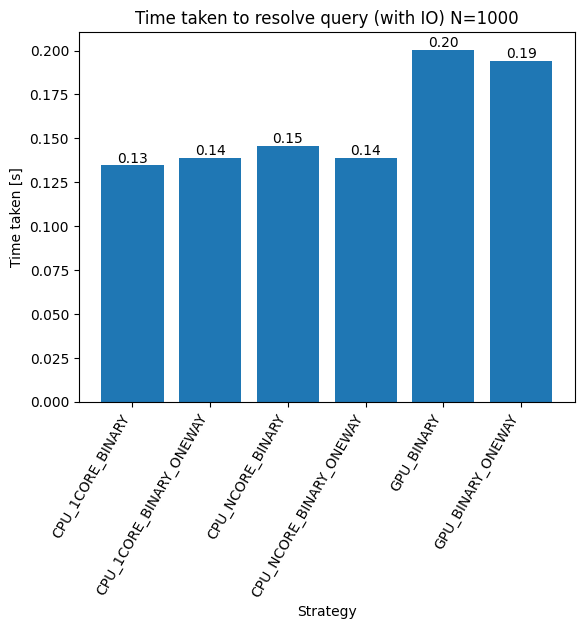

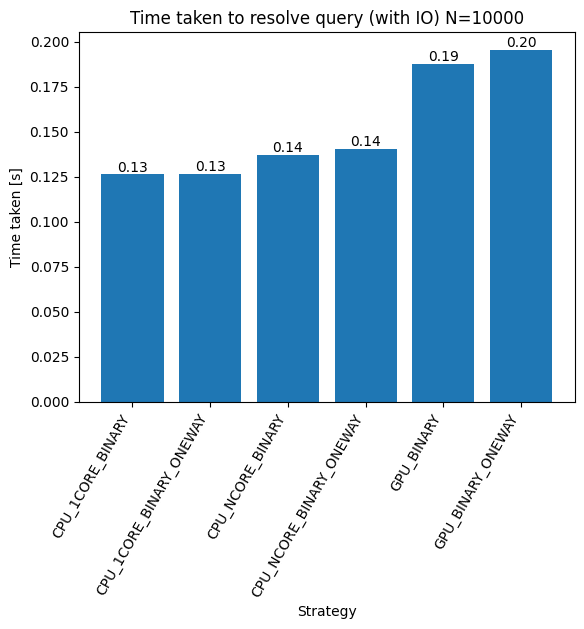

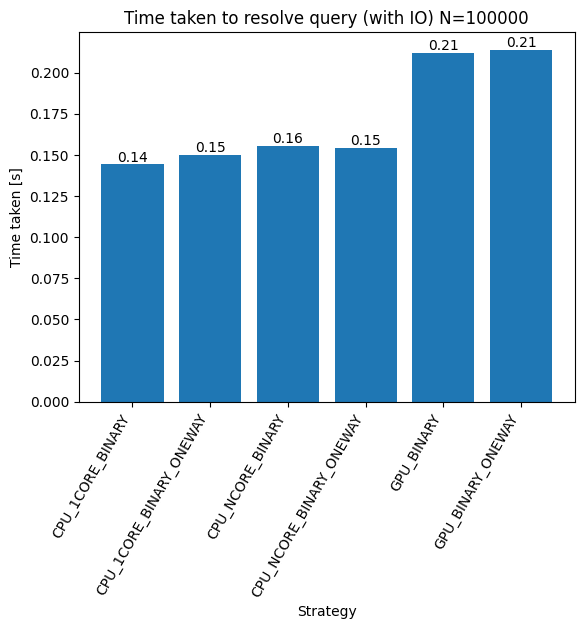

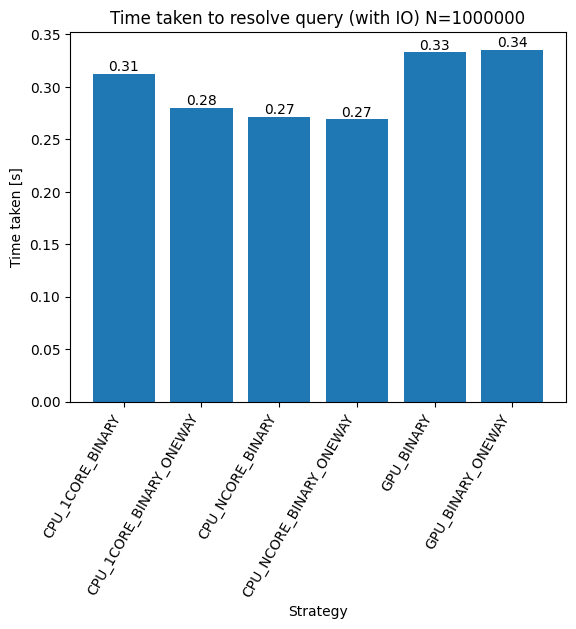

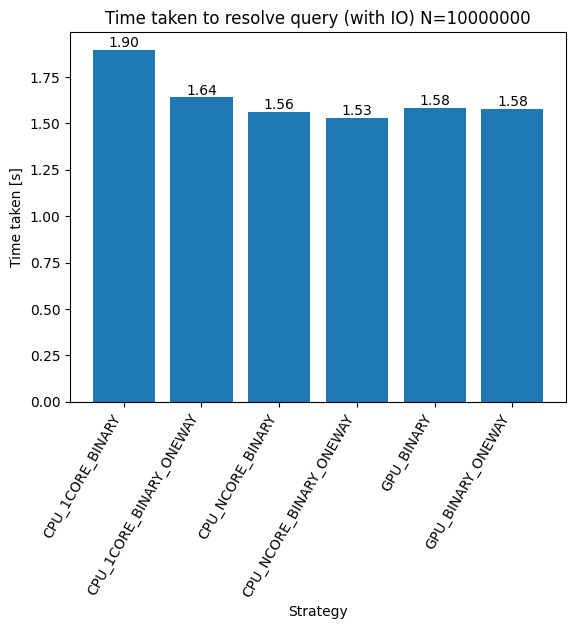

In [ ]:
boxplot_time("total_time", "s")
mean_bar_time("total_time", "s")

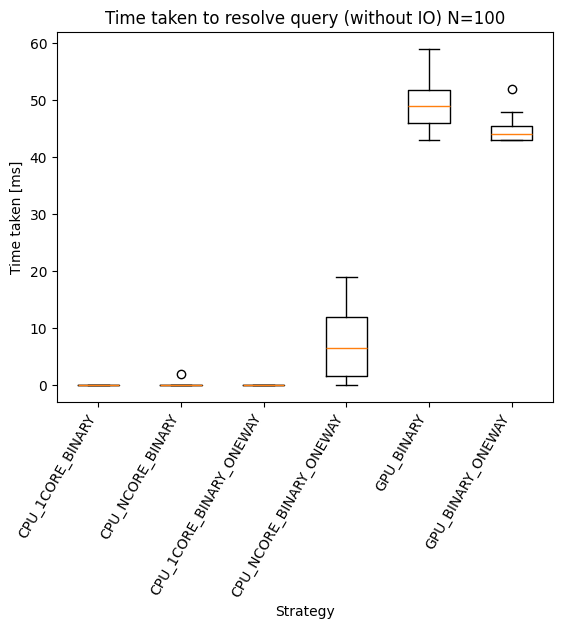

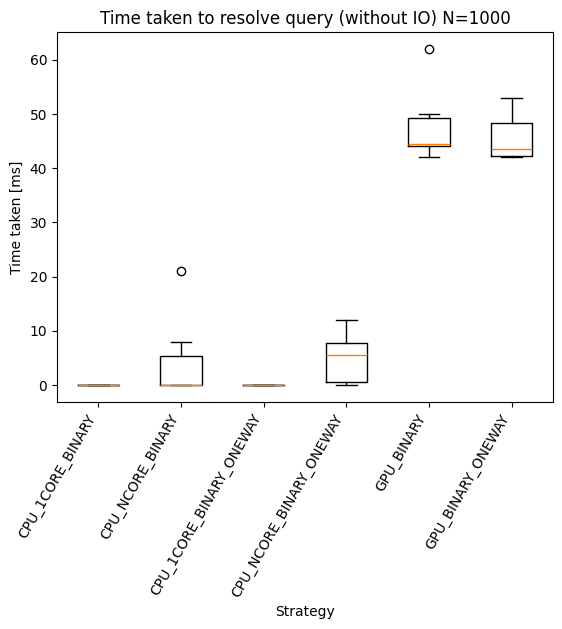

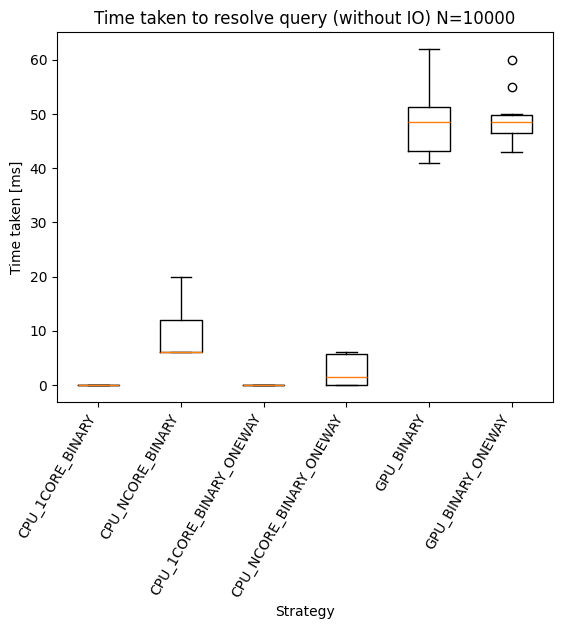

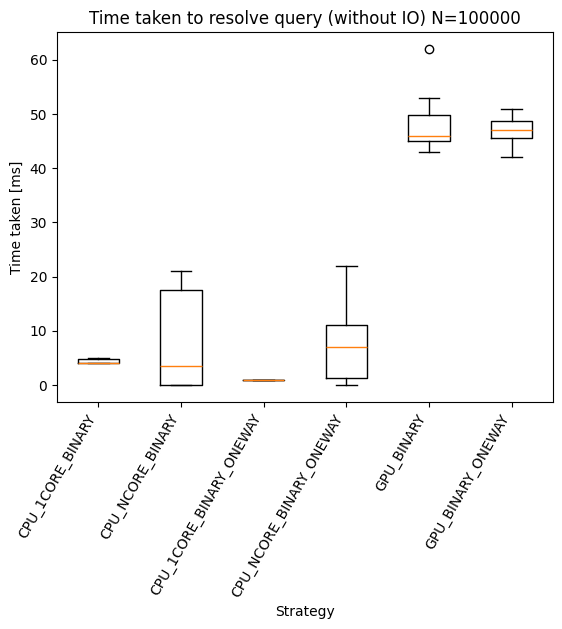

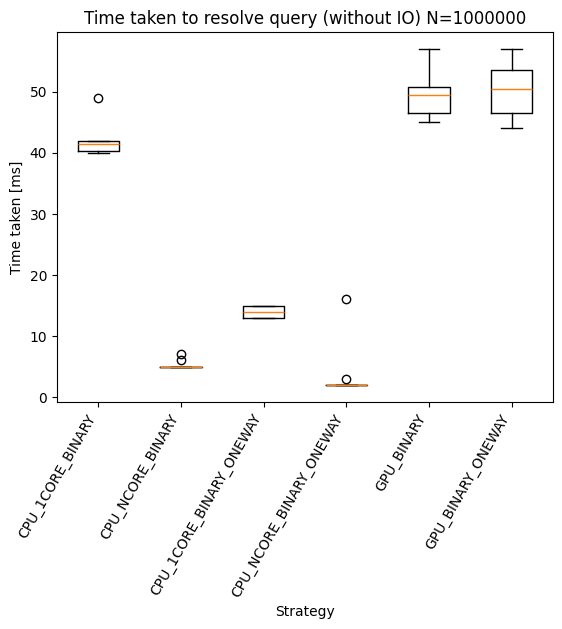

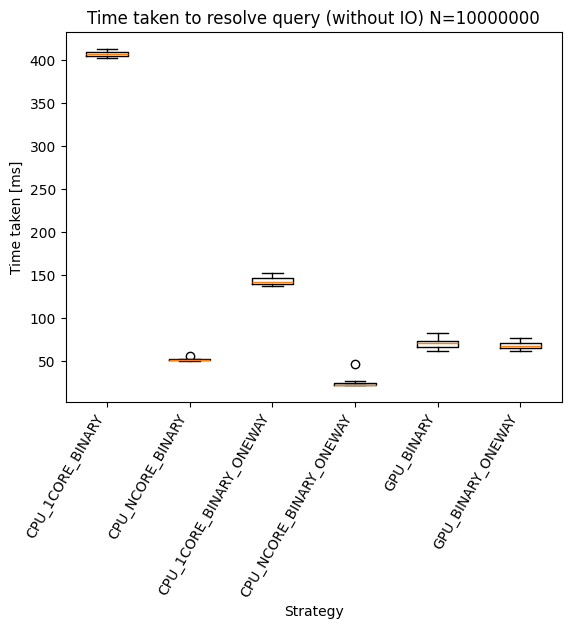

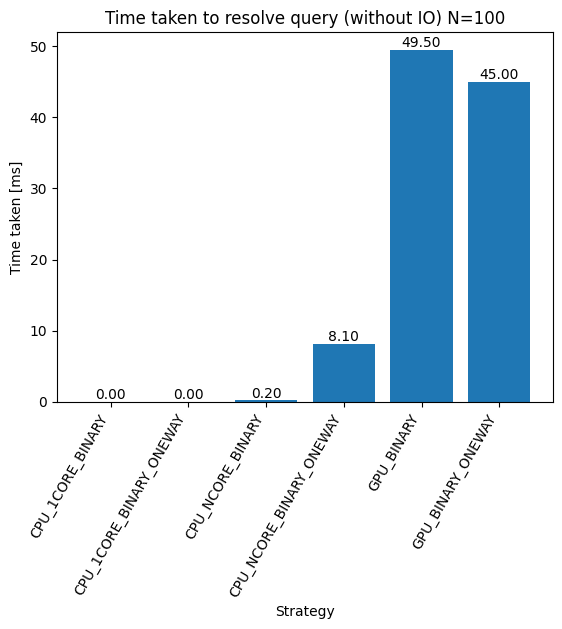

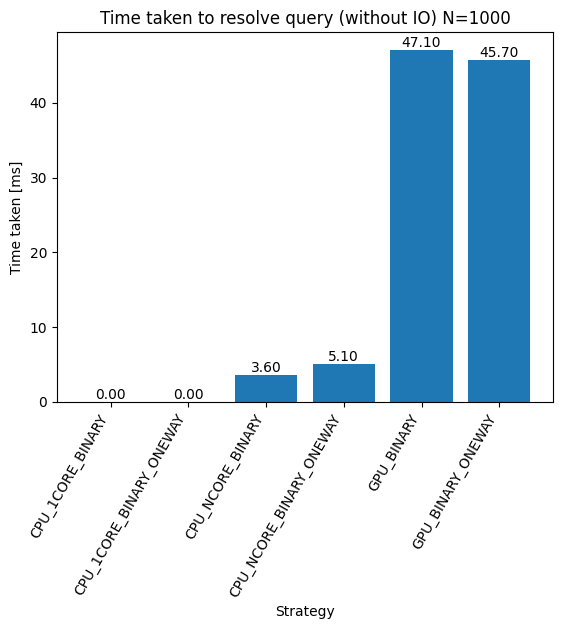

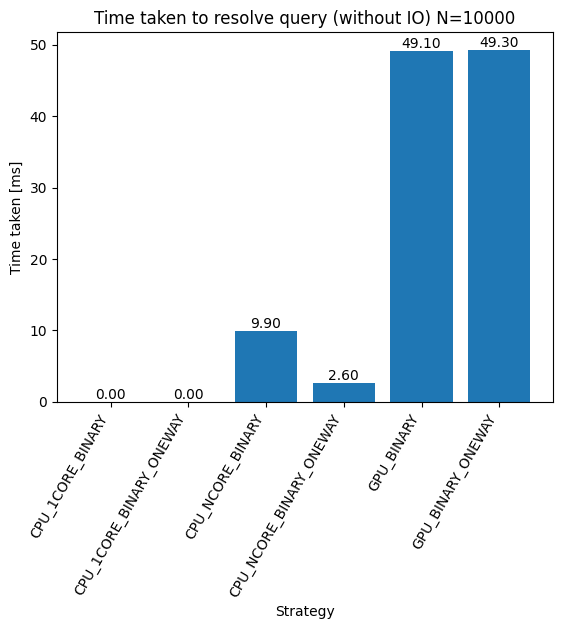

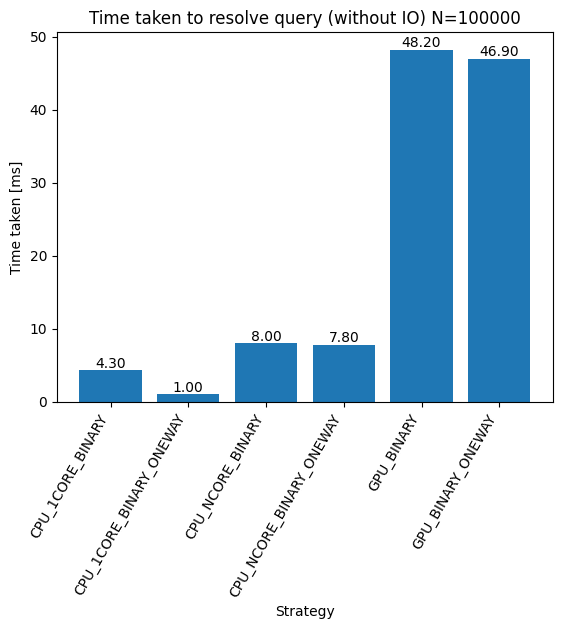

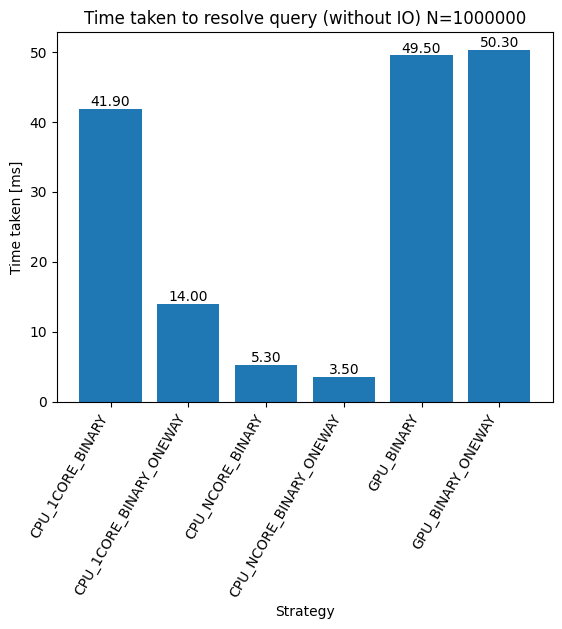

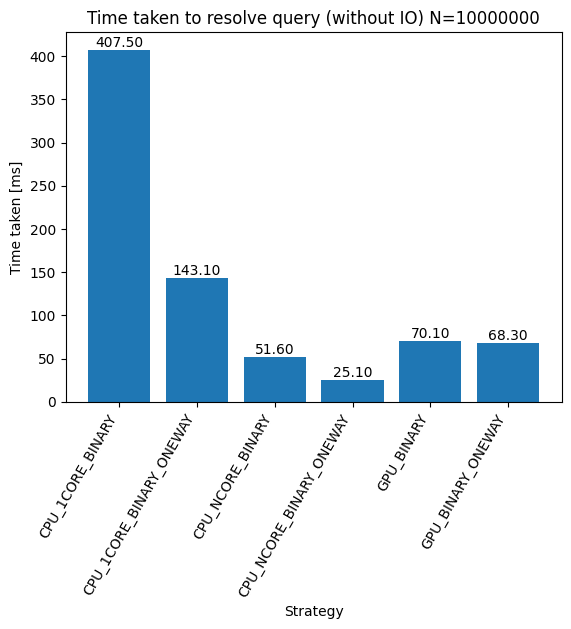

In [ ]:
boxplot_time("query_time", "ms", "out")
mean_bar_time("query_time", "ms", "out")